# Donations to L.A. County 2nd District Supervisorial Candidates

By [Matt Stiles](https://www.latimes.com/people/matt-stiles) / Los Angeles Times

Questions? matt.stiles@latimes.com

### Load Python libraries

In [1]:
import pandas as pd
import geopandas as gpd
from urllib.request import urlopen 
import pyarrow
import jenkspy
import matplotlib.pyplot as plt
%matplotlib inline
import json
import numpy as np
from altair import datum
import altair as alt
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
alt.renderers.set_embed_options(actions=False)

RendererRegistry.enable('default')

### Load all donations candidates since 2007, downloaded [here](https://efs.lacounty.gov/public_search_results.cfm?viewtype=xl&requesttimeout=1000&showall=yes&rept_type=ALLCon&CITY=la&LNM_CRIT=&FNM_CRIT=&CNM_CRIT=&ST_CRIT=&ZIP_CRIT=&ENM_CRIT=&OCC_CRIT=&S_USER=&S_OFFICE=&CID_CRIT=&CMT_CRIT=&D_BDATE=&D_EDATE=&S_BAMT=&S_EAMT=&ELECTION_ID=29&SCHEDULE=A%2CB%2CC&SUBMITBTN=Search%20Now%20%3D%3D%3E&TO_ELEC_DATE=&FROM_RPT_DATE=&TO_RPT_DATE=), and clean headers

In [2]:
src = pd.read_csv('input/donations_20201026.csv',\
                  dtype={'contributor_zip_code': 'str'}, low_memory=False)

In [3]:
src.columns = src.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [4]:
len(src)

90117

### Create a clean dataframe from the original import

In [5]:
contributions = pd.DataFrame(src)

### Clean up null values the table and other quirks

In [6]:
contributions.contributor_address_2 = contributions.contributor_address_2.fillna('')
contributions.occupation = contributions.occupation.fillna('')
contributions.employer = contributions.employer.fillna('')
contributions.description = contributions.description.fillna('')
contributions.contributor_first_name = contributions.contributor_first_name.fillna('')
contributions.contributor_zip_code_ext = contributions.contributor_zip_code_ext.fillna('')

In [7]:
contributions['amount_rcvd'] = contributions['amount_rcvd'].astype(int)
contributions['monthyear'] = pd.to_datetime(contributions['date']).map(lambda dt: dt.replace(day=1))
contributions['type'] = contributions['type'].str.replace("Small Contributor Committee", "Small Donor Committee")
contributions['first_name'] = contributions['first_name'].str.upper()
contributions['last_name'] = contributions['last_name'].str.upper()
contributions['committee_name'] = contributions['committee_name'].str.upper()
contributions['contributor_zip_code'] = contributions['contributor_zip_code'].astype(str).str.zfill(5)
contributions['contributor_zip_code'] = contributions['contributor_zip_code'].str.replace('.0','',regex=False)

In [8]:
contributions['candidate_name'] =  contributions["first_name"].str.title() + ' ' + contributions["last_name"].str.title()
contributions['candidate_name'] = contributions['candidate_name'].str.replace('Holly J. Mitchell', 'Holly Mitchell')
contributions['first_name'] = contributions['first_name'].str.replace('HOLLY J.', 'HOLLY')

### Change the zip code field so it merges with other tables later

In [9]:
contributions.rename(columns={"contributor_zip_code": "zipcode"}, inplace=True)

### What do the records look like?

In [10]:
contributions.sort_values(by='date', ascending=False).head()

,last_name,first_name,committee_id,committee_name,office_type,district_number,schedule,type,period_beg_date,period_end_date,...,int_city,int_state,int_zip_code,int_occupation,int_employer,doc_id,rec_id,x,monthyear,candidate_name
0,COOLEY,STEVE,1235308,D.A. STEVE COOLEY OFFICEHOLDER ACCOUNT,DAT,NaN,A,O,00:00.0,00:00.0,...,NaN,NaN,NaN,NaN,NaN,NaN,31.0,2523.0,2020-10-01,Steve Cooley
67586,HAHN,JANICE,1376011,JANICE HAHN FOR SUPERVISOR 2016,BSU,C04,A,I,00:00.0,00:00.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2327.0,156075.0,2020-10-01,Janice Hahn
60082,ENGLANDER,MITCHELL,1377028,MITCHELL ENGLANDER FOR SUPERVISOR 2016,CSU,C05,A,I,00:00.0,00:00.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2212.0,147635.0,2020-10-01,Mitchell Englander
60081,ENGLANDER,MITCHELL,1377028,MITCHELL ENGLANDER FOR SUPERVISOR 2016,CSU,C05,A,I,00:00.0,00:00.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2212.0,147631.0,2020-10-01,Mitchell Englander
60080,CARR,ELAN,1375984,CARR FOR SUPERVISOR 2016,CSU,NaN,A,I,00:00.0,00:00.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2189.0,146063.0,2020-10-01,Elan Carr


In [11]:
contributions.iloc[0]

last_name                                                   COOLEY
first_name                                                   STEVE
committee_id                                               1235308
committee_name              D.A. STEVE COOLEY OFFICEHOLDER ACCOUNT
office_type                                                    DAT
district_number                                                NaN
schedule                                                         A
type                                                             O
period_beg_date                                            00:00.0
period_end_date                                            00:00.0
election_date                                                  NaN
date                                                       00:00.0
amount_rcvd                                                   1000
amount_pd                                                        0
description                                                   

### Sluggify candidate names

In [12]:
contributions['candidate_slug'] =  \
    contributions["first_name"].str.lower() + '_' + contributions["last_name"].str.lower()
contributions['candidate_slug']\
= contributions['candidate_slug'].\
str.strip().str.lower().str.replace(\
                    ' ', '_').str.replace('(', '').str.replace(')', '')\
.str.replace('.', '').str.replace('\'', '')

### Process the dates now to make life easier througout

In [13]:
contributions['date'] = pd.to_datetime(contributions['date'])
contributions['year'], contributions['month'] = contributions['date'].dt.year, contributions['date'].dt.month
contributions['year'] = contributions['year'].astype(str)
contributions['month'] = contributions['month'].astype(str)
contributions['months'] = contributions['date'].dt.strftime('%m/%Y').astype(str)
contributions['week'] = contributions['date'].dt.isocalendar().week
contributions['week'] = contributions['week'].astype(str)

### Chan Jeong and Jake Jeong are the same person. Standardize the names for better aggregates. 

In [14]:
contributions.loc[(contributions.candidate_name == 'Chan Jeong'),'candidate_name']='Jake Jeong'

### Filter data for recent contributions and money in the District 2 race

In [15]:
recent_contributions = contributions[(contributions['date'] > '2018-06-30')]

### Define the 2nd District candidates

In [16]:
second_district_candidates = (['Holly Mitchell','Herb Wesson'])

### Make a dataframe with only 2nd District donations

In [17]:
districttwo = pd.DataFrame(recent_contributions[recent_contributions['candidate_name']\
                                                .isin(second_district_candidates)])

### How many donations are we talking about? 

In [18]:
len(districttwo)

5988

In [19]:
districttwo.candidate_name.value_counts()

Holly Mitchell    3402
Herb Wesson       2586
Name: candidate_name, dtype: int64

### How much did the candidates raise individually? 

In [20]:
second_district_totals = districttwo.groupby(['candidate_name'])['amount_rcvd']\
    .sum().reset_index().sort_values(by='amount_rcvd', ascending=False)

In [21]:
second_district_totals

,candidate_name,amount_rcvd
0,Herb Wesson,2563607
1,Holly Mitchell,1635217


In [22]:
sum_all_donations = second_district_totals['amount_rcvd'].sum()

### And how much has been raised by the candidates in total?

In [23]:
second_district_totals['amount_rcvd'].sum()

4198824

In [24]:
second_district_sum = districttwo.groupby(['candidate_name'])['amount_rcvd']\
    .sum().reset_index().sort_values(by='candidate_name', ascending=False)
second_district_sum.head(10)

,candidate_name,amount_rcvd
1,Holly Mitchell,1635217
0,Herb Wesson,2563607


In [25]:
second_district_avg = districttwo.groupby(['candidate_name'])['amount_rcvd']\
    .mean().reset_index().sort_values(by='candidate_name', ascending=False)

### What is each candidate's average donation size? 

In [26]:
second_district_avg.round(2)

,candidate_name,amount_rcvd
1,Holly Mitchell,480.66
0,Herb Wesson,991.34


In [27]:
districttwo.to_csv('output/district_two.csv')

### How many individual donations did each candidate receive? 

In [28]:
# Crudely remap donation 'type' codes to be more descriptive
abbr_indiv_else = {'C' : 'Other', 'I' : 'Individual', 'O' : 'Other', 'S' : 'Other'}
districttwo = districttwo.replace({"type": abbr_indiv_else})

In [29]:
second_district_indiv = pd.pivot_table(districttwo, values='amount_rcvd', \
                    index=['candidate_name'], columns=['type'], aggfunc=[np.size], fill_value='0').reset_index()

In [30]:
second_district_indiv = pd.DataFrame(second_district_indiv.to_records())

In [31]:
second_district_indiv.columns = second_district_indiv.columns.str.strip().str.lower().str.replace(',_', '')\
                    .str.replace('(', '').str.replace(')', '').str.replace("'", '')\
                    .str.replace('size, ','').str.replace(',', '')

In [32]:
second_district_indiv = pd.DataFrame(second_district_indiv)

### Which share of each candidates donations came from individuals?

In [33]:
second_district_indiv.head()

,index,candidate_name,individual,other
0,0,Herb Wesson,1821,765
1,1,Holly Mitchell,2870,532


In [34]:
second_district_indiv['share_indy'] = \
    ((second_district_indiv['individual'] /\
      (second_district_indiv['individual'] + second_district_indiv['other']))*100).round()

In [35]:
second_district_indiv['share_other'] = \
    ((second_district_indiv['other'] /\
      (second_district_indiv['individual'] + second_district_indiv['other']))*100).round()

In [36]:
second_district_indiv.head()

,index,candidate_name,individual,other,share_indy,share_other
0,0,Herb Wesson,1821,765,70.0,30.0
1,1,Holly Mitchell,2870,532,84.0,16.0


### Normalized bar chart for the share of individual donations

In [37]:
ind_other_totals = districttwo.groupby(['type', 'candidate_name']).agg({'amount_rcvd':'sum'}).reset_index()

In [38]:
ind_other_totals

,type,candidate_name,amount_rcvd
0,Individual,Herb Wesson,1693879
1,Individual,Holly Mitchell,1071413
2,Other,Herb Wesson,869728
3,Other,Holly Mitchell,563804


In [39]:
bars = alt.Chart(ind_other_totals, title='Share of donations from individuals').mark_bar().encode(
    x=alt.X('sum(amount_rcvd)', stack="normalize", title="Share of donations",axis=alt.Axis(format='%', tickCount=6)),
    y=alt.Y('candidate_name', title=""),
    color=alt.Color('type',legend=alt.Legend(title="", orient='top')),
    order=alt.Order('sum(amount_rcvd)', sort='ascending')
)
(bars).properties(height=175, width=800)

alt.Chart(...)

## When exactly is each donation? 

### How much did each candidate raise — by month — in 2019? 

In [40]:
districttwo_time = districttwo.groupby(['monthyear','year','month', 'candidate_name'], as_index=False).\
            agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

flat_columns = [''.join(t) for t in districttwo_time.columns]
districttwo_time.columns = flat_columns
districttwo_time['amount_rcvdmean'] = districttwo_time['amount_rcvdmean'].astype(int)
districttwo_time['amount_rcvdmean'] = districttwo_time['amount_rcvdmean'].round()
districttwo_time.head(10)
districttwo_time['months'] = districttwo_time['monthyear'].dt.strftime('%b').astype(str)
districttwo_time['week'] = districttwo_time['monthyear'].dt.isocalendar().week

In [41]:
districttwo_time = districttwo_time[(districttwo_time.year == '2019')]

In [42]:
districttwo_time[(districttwo_time.candidate_name == 'Jake Jeong')][['candidate_name', 'months', 'amount_rcvdsum']]

,candidate_name,months,amount_rcvdsum


In [43]:
second_district_totals['amount_rcvd'] = second_district_totals['amount_rcvd']

In [44]:
second_district_totals

,candidate_name,amount_rcvd
0,Herb Wesson,2563607
1,Holly Mitchell,1635217


In [45]:
alt.Chart(districttwo_time).mark_bar().encode(
    y='amount_rcvdsum:Q',
    x=alt.X('month:N', timeUnit='month', title='')
).properties(
    width=250,
    height=180
).facet(
    facet='candidate_name:N',
    columns=3
)

alt.FacetChart(...)

In [46]:
districttwo_time.to_csv('output/districttwo_time.csv')

### How much did they raise by ZIP? 

In [47]:
zip_totals = districttwo.groupby(['zipcode'])['amount_rcvd']\
    .sum().reset_index().sort_values(by='amount_rcvd', ascending=False)

In [48]:
zip_totals.head()

,zipcode,amount_rcvd
775,95814,129450
219,90010,93300
258,90056,74040
256,90049,71149
218,90008,70176


In [49]:
zip_totals_candidate = districttwo[districttwo['candidate_name'] == 'Albert Robles'].groupby(['zipcode'])['amount_rcvd']\
    .sum().reset_index().sort_values(by='amount_rcvd', ascending=False)
zip_totals_candidate.head()

,zipcode,amount_rcvd


In [50]:
zip_totals.to_csv('output/zip_totals.csv')

In [51]:
zip_totals_candidates = districttwo.groupby(['candidate_name', 'zipcode'])['amount_rcvd']\
    .sum().reset_index().sort_values(by='amount_rcvd', ascending=False)

---

## Geography

### Load 2nd District boundary data

In [52]:
#http://public.gis.lacounty.gov/public/rest/services/LACounty_Dynamic/Demographics/MapServer/3
district = gpd.read_file('/Users/mhustiles/data/data/GIS/LA/second-district.geojson')

### Read the zip codes boundaries

In [53]:
#http://public.gis.lacounty.gov/public/rest/services/LACounty_Dynamic/Administrative_Boundaries/MapServer/5
# zips_old = gpd.read_file('/Users/mhustiles/data/github/notebooks/\
# campaign-finance/input/la_county_gis_zip_codes/la_county_gis_zip_codes_1569271283260.geojson')
zips = gpd.read_file('/Users/mhustiles/data/github/AGStoShapefile/\
backupdir/WealthiestZipCodes2017/WealthiestZipCodesCA.geojson')

<AxesSubplot:>

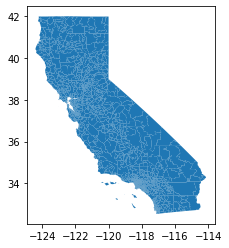

In [54]:
zips.plot()

### We only need L.A. County

In [55]:
zips = gpd.GeoDataFrame(zips[zips['COUNTY_NAME'].str.contains('Los Angeles County')])

<AxesSubplot:>

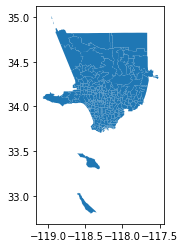

In [56]:
zips.plot()

In [57]:
zips.columns = zips.columns.str.strip().str.lower().str.replace(' ', '_')\
    .str.replace('(', '').str.replace(')', '')

In [58]:
zips.rename(columns={"id": "zipcode"}, inplace=True)
zips = zips.set_crs("EPSG:4326", allow_override=True)
zips = zips.set_crs(epsg=4326)

### We don't need all the income demographics for this story

In [59]:
zips.drop(['objectid',
           'st_abbrev',
          'hai_cy',
          'incmort_cy',
          'wlthrnk_cy',
          'domstate',
           'domcbsa',
           'cbsa_name',
           'shape__area',
           'shape__length',
           'avgnw_cy',
          'county_name'], axis=1, inplace=True)

In [60]:
zips.loc[0]

zipcode                                                   90001
name                                                Los Angeles
domcounty                                                 06037
totpop_cy                                                 59907
tothh_cy                                                  13454
medage_cy                                                  27.1
avghinc_cy                                                46931
avgval_cy                                                377591
geometry      POLYGON ((-118.247540000384 33.9890800002533, ...
Name: 0, dtype: object

In [61]:
zips_in_district = gpd.sjoin(zips, district, how="inner", op='intersects')

### Export 2nd District boundary data to MBTiles

<AxesSubplot:>

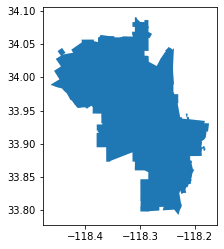

In [62]:
district.plot()

### Only zips that overlap with the district

<AxesSubplot:>

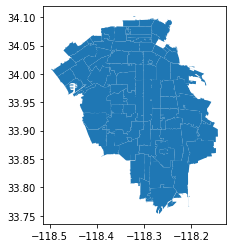

In [63]:
zips_in_district.plot()

In [64]:
zips_in_district.rename(columns={"id": "zipcode"}, inplace=True)

In [65]:
zips_in_district_geo = zips_in_district.merge(zip_totals, on='zipcode')

In [66]:
zips_in_district_geo['amount_rcvd'] = zips_in_district_geo['amount_rcvd'].astype(int).fillna('0')

In [67]:
zips_in_district_geo.sort_values(by='amount_rcvd', ascending=False).head(1)

,zipcode,name,domcounty,totpop_cy,tothh_cy,medage_cy,avghinc_cy,avgval_cy,geometry,index_right,OBJECTID,DISTRICT,LABEL,Shape.STArea(),Shape.STLength(),amount_rcvd
8,90010,Los Angeles,06037,496,276,38.6,53753,488690,"MULTIPOLYGON (((-118.31437 34.06092, -118.3143...",0,816,2,District 2,4.511283e+09,477421.592662,93300


In [68]:
zips_in_district_geo.dtypes

zipcode               object
name                  object
domcounty             object
totpop_cy              int64
tothh_cy               int64
medage_cy            float64
avghinc_cy             int64
avgval_cy              int64
geometry            geometry
index_right            int64
OBJECTID               int64
DISTRICT              object
LABEL                 object
Shape.STArea()       float64
Shape.STLength()     float64
amount_rcvd            int64
dtype: object

In [69]:
zips_in_district_export = gpd.GeoDataFrame(zips_in_district_geo)

### Export file showing all donations by distrit zips

In [70]:
zips_in_district_export.to_file('output/zips_in_district_export.shp')

---

### How much did each of the candidates raise, by zip?

In [71]:
# pivot to a wide table for mapping

sum_by_zip = pd.pivot_table(districttwo, values='amount_rcvd', index=['zipcode'], 
                            columns=['candidate_slug'], aggfunc=np.sum, fill_value=0).reset_index()

In [72]:
sum_by_zip["total"] = sum_by_zip.sum(axis=1)

In [73]:
# flatten the multiindex frame

sum_by_zip.columns = sum_by_zip.columns.to_series().str.join('')

### How much did all of the candidates raise by zip?

In [74]:
sum_by_zip = sum_by_zip.sort_values("total", ascending=False)

In [75]:
sum_by_zip.head()

candidate_slug,zipcode,herb_wesson,holly_mitchell,total
775,95814,18300,111150,129450
219,90010,81750,11550,93300
258,90056,37160,36880,74040
256,90049,41799,29350,71149
218,90008,41818,28358,70176


### Top ZIP Codes

In [76]:
sum_by_zip[['zipcode', 'total']].sort_values(by='total', ascending=False).head()

candidate_slug,zipcode,total
775,95814,129450
219,90010,93300
258,90056,74040
256,90049,71149
218,90008,70176


### How many zips donated? 

In [77]:
sum_by_zip.total.count()

810

### Which 2nd District candidate received the most in each zip? 

In [78]:
#create a dummy field because i'm bad at idxmax; 
sum_by_zip['tie'] = '0'

In [79]:
#reshape dataframe
sum_by_zip_winner = pd.DataFrame(sum_by_zip[['zipcode', 'tie','herb_wesson','holly_mitchell','total']])

In [80]:
sum_by_zip_winner['tie'] = sum_by_zip_winner['tie'].astype(int)
sum_by_zip_winner['zipcode'] = sum_by_zip_winner['zipcode'].astype(str)

### Who won each zip?

In [81]:
sum_by_zip_winner['winner_dist_two'] = sum_by_zip_winner[['tie','herb_wesson','holly_mitchell']].idxmax(axis=1)

### How much did each zip winner raise from there? 

In [82]:
sum_by_zip_winner['winner_total'] = sum_by_zip_winner[['tie','herb_wesson','holly_mitchell']].max(axis=1)

In [83]:
sum_by_zip_winner['winner_dist_two'] = sum_by_zip_winner['winner_dist_two'].str.title().str.replace('_',' ')

In [84]:
sum_by_zip_winner['winner_dist_two'].value_counts('normalize')

Herb Wesson       0.524691
Holly Mitchell    0.474074
Tie               0.001235
Name: winner_dist_two, dtype: float64

### Which were the top zips for each candidate? 

In [85]:
sum_by_zip_winner.sort_values(by='winner_total', ascending=False).head()

candidate_slug,zipcode,tie,herb_wesson,holly_mitchell,total,winner_dist_two,winner_total
775,95814,0,18300,111150,129450,Holly Mitchell,111150
219,90010,0,81750,11550,93300,Herb Wesson,81750
229,90020,0,49350,7200,56550,Herb Wesson,49350
226,90017,0,46388,19915,66303,Herb Wesson,46388
228,90019,0,43265,21395,64660,Herb Wesson,43265


In [86]:
sum_by_zip_winner.to_csv('output/sum_by_hood_winner.csv')

### Remove rows with no contributions

In [87]:
sum_by_zip_winner = sum_by_zip_winner[(sum_by_zip_winner['winner_total'] != 0)]

In [88]:
len(sum_by_zip_winner)

809

### How many zips did each candidate win?

In [89]:
sum_by_zip_winner.winner_dist_two.value_counts()

Herb Wesson       425
Holly Mitchell    384
Name: winner_dist_two, dtype: int64

---

### How much did the candidates raise in the 2nd District ZIPs alone? 

In [90]:
donations_in_district_zips = zips_in_district.merge(zip_totals_candidates,on='zipcode')

### Share raised inside the district raised by all the candidates? 

In [91]:
((donations_in_district_zips.amount_rcvd.sum() /second_district_totals['amount_rcvd'].sum()) * 100).round(3)

35.166

### Share raised inside the district raised by each candidate? 

In [92]:
in_district_totals = donations_in_district_zips.groupby(['candidate_name']).agg('sum').reset_index()

In [93]:
in_district_totals[['candidate_name','amount_rcvd']]

,candidate_name,amount_rcvd
0,Herb Wesson,1020129
1,Holly Mitchell,456448


In [94]:
in_district_share = in_district_totals.merge(second_district_sum, on='candidate_name')
in_district_share_slim = pd.DataFrame(in_district_share[['candidate_name','amount_rcvd_y', 'amount_rcvd_x']])

In [95]:
in_district_share.head(10)

,candidate_name,totpop_cy,tothh_cy,medage_cy,avghinc_cy,avgval_cy,index_right,OBJECTID,Shape.STArea(),Shape.STLength(),amount_rcvd_x,amount_rcvd_y
0,Herb Wesson,2998205,984629,2666.8,5929564,45201485,0,60384,3.338349e+11,3.532920e+07,1020129,2563607
1,Holly Mitchell,2592083,884984,2393.0,5398663,41805669,0,53040,2.932334e+11,3.103240e+07,456448,1635217


### What share did candidates raise from outside the district?

In [96]:
in_district_share_slim.rename(columns={"amount_rcvd_y": "total_raised",\
                                      "amount_rcvd_x": "inside_raised"}, inplace=True)

In [97]:
in_district_share_slim['share_inside'] = ((in_district_share_slim['inside_raised'] /\
                                   in_district_share_slim['total_raised'] ) *100).round()

In [98]:
in_district_share_slim['share_outside'] = 100 - in_district_share_slim['share_inside']

In [99]:
in_district_share_slim.head(6)

,candidate_name,total_raised,inside_raised,share_inside,share_outside
0,Herb Wesson,2563607,1020129,40.0,60.0
1,Holly Mitchell,1635217,456448,28.0,72.0


In [100]:
in_district_share_slim[['candidate_name','share_inside','share_outside']]\
    .to_csv('output/in_district_share_slim.csv')

### Merge the geography back onto our 2nd District winners table

In [101]:
totals_by_LA_zips = zips.merge(sum_by_zip_winner, on='zipcode')

In [102]:
totals_by_LA_zips_slim = totals_by_LA_zips[['zipcode','geometry','herb_wesson','holly_mitchell', 'total','winner_dist_two','winner_total']]

### Export geojson for web app and Turf

In [103]:
totals_by_LA_zips_slim.to_file('output/second-district-zips-update.geojson', driver='GeoJSON')
totals_by_LA_zips_slim.to_file('/Users/mhustiles/data/github/bigbuilder/bigbuilder/pages/county-supervisor-2nd-district-campaign-donations/static/second-district-zips-update.geojson', driver='GeoJSON')

### Generate winners by zips to MBTiles for Mapbox

In [104]:
!tippecanoe --generate-ids --force -r1 -pk -pf -o \
output/second-district-zips-update.mbtiles \
output/second-district-zips-update.geojson

For layer 0, using name "seconddistrictzipsupdate"
251 features, 341765 bytes of geometry, 3915 bytes of separate metadata, 4017 bytes of string pool
  99.9%  14/2809/6542  


---

### Wesson donations

In [105]:
wesson = districttwo[districttwo['candidate_name'] == 'Herb Wesson']

In [106]:
wessonoutside = wesson[wesson['type'] == 'Other']

In [107]:
wessonlarge = wesson[wesson['amount_rcvd'] == 1500]
len(wessonlarge)

1241

### Mitchell donations

In [108]:
mitchell = districttwo[districttwo['candidate_name'] == 'Holly Mitchell']

In [109]:
mitchelloutside = mitchell[mitchell['type'] == 'Other']

In [110]:
mitchelllarge = mitchell[mitchell['amount_rcvd'] == 1500]
len(mitchelllarge)

526